# Reader from Prospector

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab

In [1]:
import time, sys, os
from copy import deepcopy
import numpy as np
from sedpy.observate import load_filters

from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer

from prospect.sources.constants import cosmo

try:
    from exspect.utils import build_mock
    from exspect.utils import set_sdss_lsf, load_sdss
    from exspect.utils import fit_continuum, eline_mask
except(ImportError):
    pass

In [2]:
from prospect.io import read_results as reader

In [3]:
ts = time.strftime("%y%b%d-%H.%M", time.localtime())
ts

'23May31-17.42'

In [4]:
fsps_output_dir="./output_examples"

In [5]:
filenames = os.listdir(fsps_output_dir)

In [6]:
filenames

['mock_parametric_phot_23May29-09.04_result.h5',
 'mock_parametric_spec_23May29-12.28_result.h5',
 'mock_parametric_specphot_23May29-18.30_result.h5']

## Pure photometric sample

 'mock_parametric_phot_23May29-09.04_result.h5

In [7]:
filename = filenames[0]

In [8]:
hfile = os.path.join(fsps_output_dir,filename)

In [9]:
out, out_obs, out_model = reader.results_from(hfile)

In [10]:
out["theta_labels"]

['zred', 'mass', 'logzsol', 'dust2', 'tage', 'tau', 'gas_logu']

In [11]:
out['bestfit']

{'parameter': array([ 9.99259480e-02,  6.67750874e+09,  1.56919395e-01,  2.63805200e-02,
         4.18373607e+00,  8.56755066e-01, -2.58489230e+00]),
 'photometry': array([4.03667541e-09, 3.89171027e-09, 6.19176531e-09, 1.65949106e-08,
        2.68497286e-08, 3.49089598e-08, 4.25967946e-08, 5.69858966e-08,
        6.29439073e-08, 5.93953187e-08]),
 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'spectrum': array([ 1.79790797e-11, -2.04135080e-14, -3.41037436e-16, ...,
         5.98711271e-10,  5.99135258e-10,  5.81351464e-10]),
 'mfrac': 0.6541053475947789}

In [12]:
zred_fitted = out['bestfit']['parameter'][0]
mass_fitted = out['bestfit']['parameter'][1]
logzsol_fitted = out['bestfit']['parameter'][2]
dust2_fitted = out['bestfit']['parameter'][3]
tage_fitted = out['bestfit']['parameter'][4]
tau_fitted = out['bestfit']['parameter'][5]
gas_logu = out['bestfit']['parameter'][6]

In [13]:
zred_fitted

0.09992594797670455

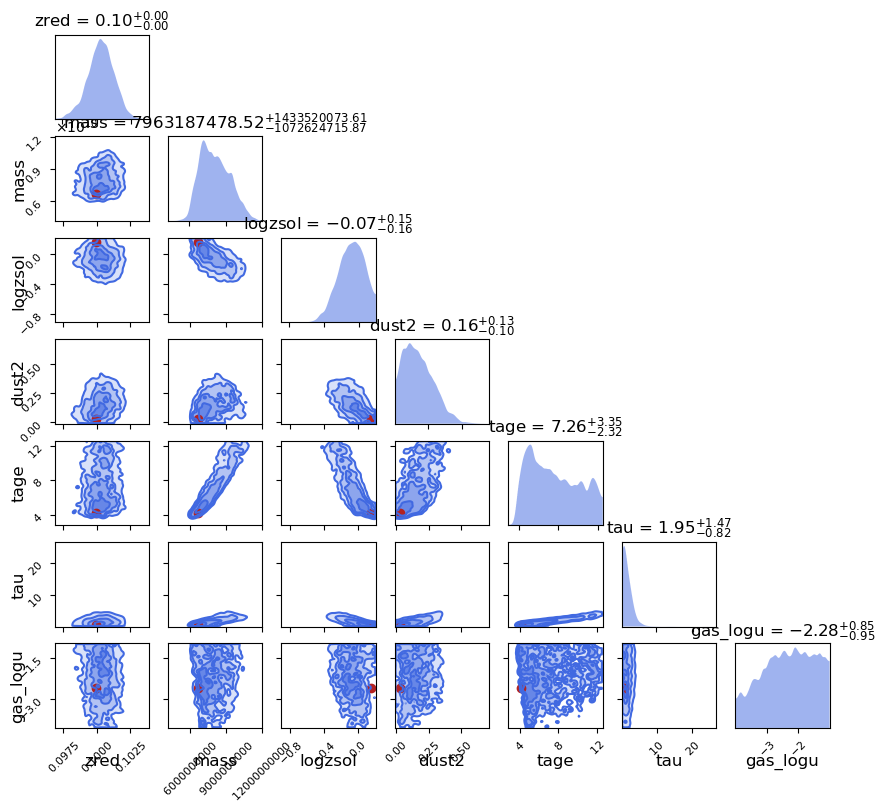

In [14]:
import matplotlib.pyplot as pl
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = pl.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, weights=out["weights"], color="royalblue", show_titles=True)

from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

In [15]:
bsed = out["bestfit"]

In [16]:
bsed

{'parameter': array([ 9.99259480e-02,  6.67750874e+09,  1.56919395e-01,  2.63805200e-02,
         4.18373607e+00,  8.56755066e-01, -2.58489230e+00]),
 'photometry': array([4.03667541e-09, 3.89171027e-09, 6.19176531e-09, 1.65949106e-08,
        2.68497286e-08, 3.49089598e-08, 4.25967946e-08, 5.69858966e-08,
        6.29439073e-08, 5.93953187e-08]),
 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'spectrum': array([ 1.79790797e-11, -2.04135080e-14, -3.41037436e-16, ...,
         5.98711271e-10,  5.99135258e-10,  5.81351464e-10]),
 'mfrac': 0.6541053475947789}

Text(0, 0.5, '$\\chi_{\\rm best}$')

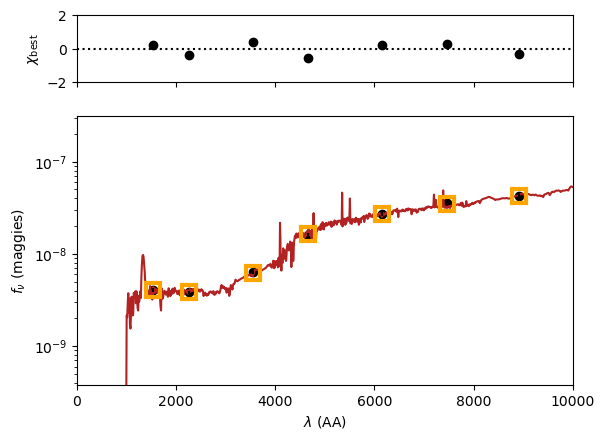

In [17]:
import matplotlib.pyplot as pl
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(0, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
param = bsed['parameter']
zfit = param[0]
ax.plot(bsed["restframe_wavelengths"] * (1+zfit), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")